In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, SelectPercentile, SelectFromModel, f_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from datetime import timedelta
from sklearn.linear_model import LinearRegression

%matplotlib inline

# Урок 5. Кейс 1. Аномалии и артефакты.

**1. Прочитайте базу my_BRENT2019.csv**

In [2]:
data = pd.read_csv('./datasets/my_BRENT2019.csv', index_col=[0], parse_dates=[0]).sort_index()

data.head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Дата,,,,,,,,,,,
2010-09-01,76.37,2010,9,1,3,244,35,2,0,0,0
2010-09-02,76.89,2010,9,2,3,245,35,3,0,0,0
2010-09-03,76.57,2010,9,3,3,246,35,4,0,0,0
2010-09-04,76.62,2010,9,4,3,247,35,5,0,0,0
2010-09-05,76.63,2010,9,5,3,248,35,6,0,1,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2667 entries, 2010-09-01 to 2019-09-01
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Значение         2667 non-null   float64
 1   year             2667 non-null   int64  
 2   month            2667 non-null   int64  
 3   dayofmonth       2667 non-null   int64  
 4   quarter          2667 non-null   int64  
 5   dayofyear        2667 non-null   int64  
 6   weekofyear       2667 non-null   int64  
 7   dayofweek        2667 non-null   int64  
 8   is_holiday       2667 non-null   int64  
 9   is_prev_holiday  2667 non-null   int64  
 10  is_next_holiday  2667 non-null   int64  
dtypes: float64(1), int64(10)
memory usage: 250.0 KB


In [4]:
# Проверка индексов на дубли
data[data.index.duplicated(keep=False)].size

0

In [5]:
# Проверка на пропуски в индексах
pd.date_range('2010-09-01', '2019-09-01', freq="D").size == data.index.size

False

In [6]:
# Проверка на пропуски в данных
data[data['Значение'].isna()]

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Дата,,,,,,,,,,,


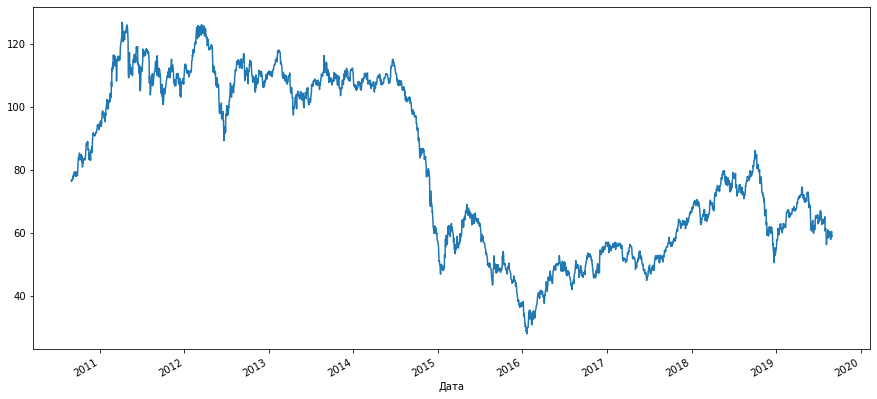

In [7]:
plt.figure( figsize=(15, 7))
data['Значение'].plot()
plt.show()

В данных имеются пропуски, но они пропадут после недельного ресэмплинга.

**2. Добавьте первые разности и стоимости доллара и евро к рублю (можно добавить их 1-е разности).**

**3. Сделайте ее перрасчет (ресемплинг) в представление по неделям.**

### Добавление экзогенных признаков

Сперва добавим курсы валют, затем сделаем ресэмплинг, и, если потребуется, заполним пропуски.

In [8]:
# курс доллара
usd = pd.read_excel('./datasets/usd_2010_2019.xlsx', index_col=[0], parse_dates=[0], usecols=[1,2]).rename(columns={ 'curs': 'usd' })
usd.head()

,usd
data,
2010-09-01,30.8669
2010-09-02,30.8001
2010-09-03,30.6858
2010-09-04,30.6922
2010-09-07,30.5771


In [9]:
# курс евро
eur = pd.read_excel('./datasets/eur_2010_2019.xlsx', index_col=[0], parse_dates=[0], usecols=[1,2]).rename(columns={ 'curs': 'eur' })
eur.head()

,eur
data,
2010-09-01,39.0127
2010-09-02,39.1654
2010-09-03,39.2901
2010-09-04,39.3505
2010-09-07,39.4720


In [10]:
# данные с экзогенными признаками
data_with_currency = data.merge(usd, how='left', left_index=True, right_index=True).merge(eur, how='left', left_index=True, right_index=True)
data_with_currency.head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday,usd,eur
Дата,,,,,,,,,,,,,
2010-09-01,76.37,2010,9,1,3,244,35,2,0,0,0,30.8669,39.0127
2010-09-02,76.89,2010,9,2,3,245,35,3,0,0,0,30.8001,39.1654
2010-09-03,76.57,2010,9,3,3,246,35,4,0,0,0,30.6858,39.2901
2010-09-04,76.62,2010,9,4,3,247,35,5,0,0,0,30.6922,39.3505
2010-09-05,76.63,2010,9,5,3,248,35,6,0,1,0,NaN,NaN


### Ресэмплинг модели

In [11]:
data_week = data_with_currency.resample('W').mean().sort_index()
data_week.head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday,usd,eur
Дата,,,,,,,,,,,,,
2010-09-05,76.616000,2010.0,9.000000,3.000000,3.000000,246.000000,35.0,4.000000,0.000000,0.2,0.000000,30.76125,39.204675
2010-09-12,77.673333,2010.0,9.000000,8.500000,3.000000,251.500000,36.0,2.500000,0.166667,0.0,0.166667,30.79402,39.293360
2010-09-19,78.693333,2010.0,9.000000,15.666667,3.000000,258.666667,37.0,2.666667,0.000000,0.0,0.000000,30.78775,39.769300
2010-09-26,78.518333,2010.0,9.000000,22.666667,3.000000,265.666667,38.0,2.666667,0.000000,0.0,0.000000,31.01200,40.988325
2010-10-03,81.211667,2010.0,9.333333,19.666667,3.333333,272.666667,39.0,2.666667,0.000000,0.0,0.000000,30.53220,41.274425


### Обработка пропусков

In [12]:
data_week.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 470 entries, 2010-09-05 to 2019-09-01
Freq: W-SUN
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Значение         469 non-null    float64
 1   year             469 non-null    float64
 2   month            469 non-null    float64
 3   dayofmonth       469 non-null    float64
 4   quarter          469 non-null    float64
 5   dayofyear        469 non-null    float64
 6   weekofyear       469 non-null    float64
 7   dayofweek        469 non-null    float64
 8   is_holiday       469 non-null    float64
 9   is_prev_holiday  469 non-null    float64
 10  is_next_holiday  469 non-null    float64
 11  usd              461 non-null    float64
 12  eur              461 non-null    float64
dtypes: float64(13)
memory usage: 51.4 KB


In [13]:
# Проверка на пропуски в индексах
pd.date_range('2010-09-05', '2019-09-01', freq="W").size == data_week.index.size

True

Пропусков в индексах нет.

In [14]:
# проверка на пропуски в данных
dropped_indexes = data_week[data_week.isnull().any(axis=1)].index
data_week.loc[dropped_indexes]

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday,usd,eur
Дата,,,,,,,,,,,,,
2011-01-09,94.558000,2011.0,1.0,6.000000,1.0,6.000000,1.0,3.000000,0.000000,0.0,0.000000,NaN,NaN
2011-10-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-08,112.974000,2012.0,1.0,5.200000,1.0,5.200000,1.0,3.200000,0.000000,0.0,0.200000,NaN,NaN
2013-01-06,110.688000,2012.8,3.2,9.200000,1.6,76.200000,1.0,3.000000,0.000000,0.2,0.200000,NaN,NaN
2015-01-11,50.908333,2015.0,1.0,7.666667,1.0,7.666667,2.0,2.666667,0.000000,0.0,0.000000,NaN,NaN
2016-01-10,35.982000,2016.0,1.0,6.000000,1.0,6.000000,1.0,2.000000,0.000000,0.0,0.000000,NaN,NaN
2017-01-08,56.578333,2017.0,1.0,4.666667,1.0,4.666667,1.0,2.666667,0.166667,0.0,0.166667,NaN,NaN
2018-01-07,67.578000,2018.0,1.0,4.200000,1.0,4.200000,1.0,3.200000,0.000000,0.0,0.200000,NaN,NaN
2019-01-06,55.916000,2018.8,3.2,9.200000,1.6,76.000000,1.0,3.000000,0.000000,0.2,0.200000,NaN,NaN


Нет подряд идущих пропущенных значений, поэтому заменим пропуски средним по соседним значениям.

In [15]:
one_week = timedelta(weeks=1)

for index in dropped_indexes:
    for column in data_week.columns:
        prev = data_week.iloc[data_week.index == index - one_week][column].values[0]
        next = data_week.iloc[data_week.index == index + one_week][column].values[0]
        curr = (prev + next) / 2
        
        data_week.loc[index][column] = curr

In [16]:
data_week.loc[dropped_indexes]

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday,usd,eur
Дата,,,,,,,,,,,,,
2011-01-09,95.900833,2010.583333,5.583333,18.583333,2.25,157.750000,27.0,2.666667,0.083333,0.166667,0.000,30.380800,39.806942
2011-10-16,106.616667,2011.000000,10.000000,13.500000,4.00,286.500000,41.0,3.500000,0.000000,0.083333,0.000,31.877975,43.102825
2012-01-08,109.797917,2011.500000,6.500000,20.083333,2.50,187.083333,27.0,2.583333,0.000000,0.083333,0.125,31.610487,40.745858
2013-01-06,110.378833,2012.500000,6.500000,18.333333,2.50,185.833333,27.0,2.833333,0.000000,0.100000,0.100,30.454262,40.021813
2015-01-11,52.764833,2014.700000,4.300000,16.933333,1.90,117.133333,2.0,2.633333,0.000000,0.183333,0.100,60.548475,72.528762
2016-01-10,34.095250,2015.500000,6.500000,21.250000,2.50,188.250000,27.5,1.750000,0.000000,0.125000,0.000,74.217463,80.988767
2017-01-08,55.958000,2016.500000,6.500000,19.750000,2.50,187.250000,27.0,2.250000,0.000000,0.000000,0.125,60.276950,63.407763
2018-01-07,67.739167,2017.500000,6.500000,19.083333,2.50,186.083333,27.0,2.583333,0.000000,0.083333,0.125,57.362988,68.357350
2019-01-06,56.539833,2018.500000,6.500000,18.333333,2.50,185.333333,27.0,2.833333,0.000000,0.100000,0.100,67.982262,77.879662


Удалим из наблюдений признак `dayofyear`, так как он коррелирует с признаком `weekofyear`.

In [17]:
# проверка корреляции признаков дня в году и недели в году
np.corrcoef(data_week['dayofyear'], data_week['weekofyear'])

array([[1.        , 0.99032937],
       [0.99032937, 1.        ]])

Так же удалим признак `dayofweek`, так как в недельном представлении он не информативный.

In [18]:
data_week.drop(['dayofweek', 'dayofyear'], axis=1, inplace=True)
data_week.head()

,Значение,year,month,dayofmonth,quarter,weekofyear,is_holiday,is_prev_holiday,is_next_holiday,usd,eur
Дата,,,,,,,,,,,
2010-09-05,76.616000,2010.0,9.000000,3.000000,3.000000,35.0,0.000000,0.2,0.000000,30.76125,39.204675
2010-09-12,77.673333,2010.0,9.000000,8.500000,3.000000,36.0,0.166667,0.0,0.166667,30.79402,39.293360
2010-09-19,78.693333,2010.0,9.000000,15.666667,3.000000,37.0,0.000000,0.0,0.000000,30.78775,39.769300
2010-09-26,78.518333,2010.0,9.000000,22.666667,3.000000,38.0,0.000000,0.0,0.000000,31.01200,40.988325
2010-10-03,81.211667,2010.0,9.333333,19.666667,3.333333,39.0,0.000000,0.0,0.000000,30.53220,41.274425


### Добавление эндогенных признаков

In [19]:
# первые разности
data_week['diff1'] = data_week['Значение'].diff(1)
data_week['diff1_usd'] = data_week['usd'].diff(1)
data_week['diff1_eur'] = data_week['eur'].diff(1)

data_week.head()

,Значение,year,month,dayofmonth,quarter,weekofyear,is_holiday,is_prev_holiday,is_next_holiday,usd,eur,diff1,diff1_usd,diff1_eur
Дата,,,,,,,,,,,,,,
2010-09-05,76.616000,2010.0,9.000000,3.000000,3.000000,35.0,0.000000,0.2,0.000000,30.76125,39.204675,NaN,NaN,NaN
2010-09-12,77.673333,2010.0,9.000000,8.500000,3.000000,36.0,0.166667,0.0,0.166667,30.79402,39.293360,1.057333,0.03277,0.088685
2010-09-19,78.693333,2010.0,9.000000,15.666667,3.000000,37.0,0.000000,0.0,0.000000,30.78775,39.769300,1.020000,-0.00627,0.475940
2010-09-26,78.518333,2010.0,9.000000,22.666667,3.000000,38.0,0.000000,0.0,0.000000,31.01200,40.988325,-0.175000,0.22425,1.219025
2010-10-03,81.211667,2010.0,9.333333,19.666667,3.333333,39.0,0.000000,0.0,0.000000,30.53220,41.274425,2.693333,-0.47980,0.286100


In [20]:
# добавим историю за 5 недель для значений и первых разностей цены нефти и курсов валют
p = 60

# значение цены нефти
for i in range(p):
    offset = i + 1
    data_week[f't_{offset}'] = 0
    data_week[f't_{offset}'][offset:] = data_week['Значение'][:-offset]


for i in range(p):
    offset = i + 1
    data_week[f'd_{offset}'] = 0
    data_week[f'd_{offset}'][offset:] = data_week['diff1'][:-offset]

# значение курса доллара
for i in range(p):
    offset = i + 1
    data_week[f'usd_t_{offset}'] = 0
    data_week[f'usd_t_{offset}'][offset:] = data_week['usd'][:-offset]


for i in range(p):
    offset = i + 1
    data_week[f'eur_t_{offset}'] = 0
    data_week[f'eur_t_{offset}'][offset:] = data_week['eur'][:-offset]

data_week.head(10)

,Значение,year,month,dayofmonth,quarter,weekofyear,is_holiday,is_prev_holiday,is_next_holiday,usd,...,eur_t_51,eur_t_52,eur_t_53,eur_t_54,eur_t_55,eur_t_56,eur_t_57,eur_t_58,eur_t_59,eur_t_60
Дата,,,,,,,,,,,,,,,,,,,,,
2010-09-05,76.616000,2010.0,9.000000,3.000000,3.000000,35.0,0.000000,0.200000,0.000000,30.761250,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-09-12,77.673333,2010.0,9.000000,8.500000,3.000000,36.0,0.166667,0.000000,0.166667,30.794020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-09-19,78.693333,2010.0,9.000000,15.666667,3.000000,37.0,0.000000,0.000000,0.000000,30.787750,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-09-26,78.518333,2010.0,9.000000,22.666667,3.000000,38.0,0.000000,0.000000,0.000000,31.012000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-10-03,81.211667,2010.0,9.333333,19.666667,3.333333,39.0,0.000000,0.000000,0.000000,30.532200,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-10-10,84.146667,2010.0,10.000000,6.666667,4.000000,40.0,0.000000,0.166667,0.000000,30.114575,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-10-17,83.498333,2010.0,10.000000,13.666667,4.000000,41.0,0.166667,0.000000,0.166667,29.991600,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-10-24,82.795000,2010.0,10.000000,20.666667,4.000000,42.0,0.000000,0.000000,0.000000,30.617600,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-10-31,83.361667,2010.0,10.000000,27.666667,4.000000,43.0,0.000000,0.000000,0.000000,30.468150,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Визуализация аномалий. Статистичческий метод по правилу 3 сигм для первых разностей.

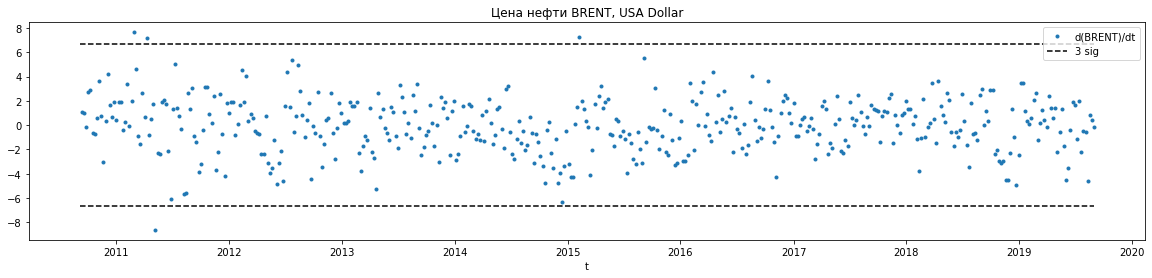

In [21]:
s_brent = np.std(data_week['diff1']) * 3

plt.figure(figsize=(20,4))

plt.plot(data_week.index, data_week['diff1'], '.', label='d(BRENT)/dt')
plt.plot(data_week.iloc[[0,-1]].index, [s_brent, s_brent], '--k', label ='3 sig')
plt.plot(data_week.iloc[[0,-1]].index, [-s_brent, -s_brent],'--k')
plt.xlabel('t')
plt.legend()
plt.title('Цена нефти BRENT, USA Dollar')
plt.show()

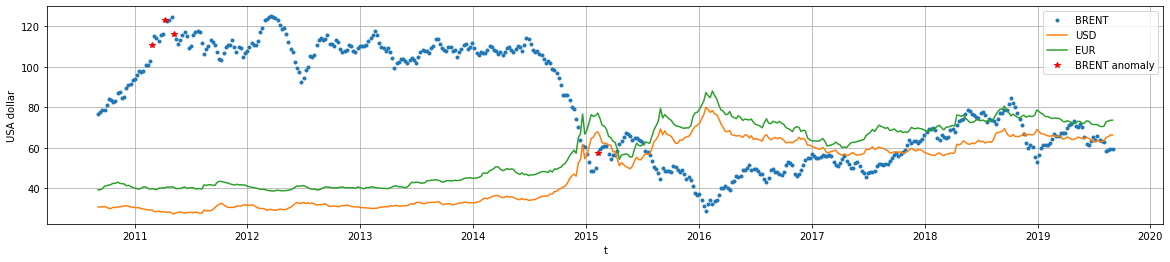

In [22]:
ind_anomal_brent = np.where(abs(data_week['diff1'] )> s_brent)[0]

plt.figure(figsize=(20,4))

plt.plot(data_week.index, data_week['Значение'], '.', label='BRENT')
plt.plot(data_week.index, data_week['usd'], '-', label='USD')
plt.plot(data_week.index, data_week['eur'], '-', label='EUR')
plt.plot(data_week.iloc[ind_anomal_brent].index, data_week['Значение'].values[ind_anomal_brent], '*r', label='BRENT anomaly')
plt.ylabel('USA dollar')
plt.grid()
plt.xlabel('t')
plt.legend()
plt.show()

### Визуализация аномалий. Статистичческий метод скользящего окна.

In [23]:
# статистический метод скользящего окна
s_brent_scaled = (data_week['diff1'])/data_week['Значение']
brent_roling_std = pd.DataFrame(data=s_brent_scaled, index=data_week.index).rolling(54).std()
three_sigm = np.std(s_brent_scaled)*3 

plt.figure(figsize=(20,4))

plt.plot(data_week.index, s_brent_scaled, '.', label='d(BRENT)/dt scaled')
plt.plot(data_week.iloc[[0,-1]].index, [three_sigm, three_sigm],'--k',label ='3 sig')
plt.plot(data_week.iloc[[0,-1]].index, [-three_sigm, -three_sigm],'--k')

plt.plot(std_d_brent.index, brent_roling_std*3, '--r', label = 'std*3 по году')
plt.plot(std_d_brent.index, -brent_roling_std*3, '--r')

plt.xlabel('t')
plt.legend()
plt.grid()
plt.title('Цена нефти Brent, USA Dollar')
plt.show()

NameError: name 'std_d_brent' is not defined

### Визуализация аномалий. Кластерный анализ.

Число кластеров с масштабированием:  4


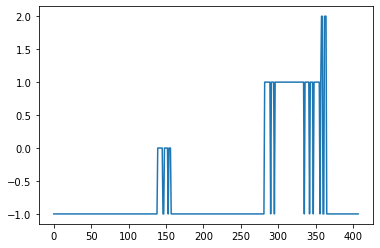

In [24]:
scl = StandardScaler()
X_scaled = scl.fit_transform(data_week.iloc[p+2:,:].values)

clast = DBSCAN(eps=8, leaf_size=1, min_samples=3)
X_scale_clast = clast.fit_predict(X_scaled)

ind_= np.where(X_scale_clast !=-1)[0]
print('Число кластеров с масштабированием: ',len(np.unique(X_scale_clast)-1))

plt.plot(X_scale_clast)
plt.show()

[]

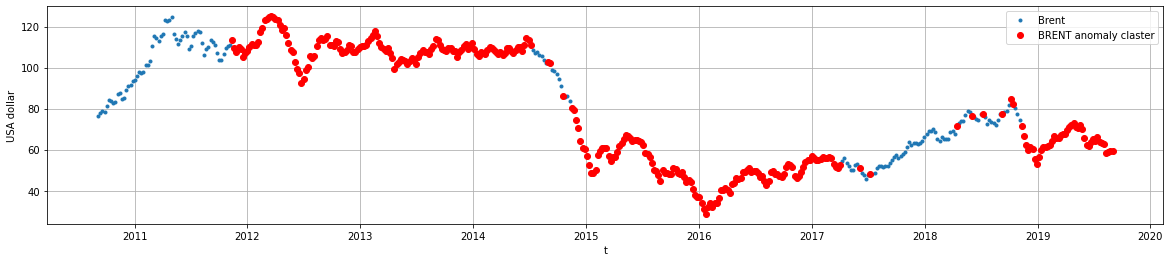

In [25]:
ind_anomal_brent_c = np.array(np.where(X_scale_clast ==-1)[0])+p+2  

plt.figure(figsize=(20,4))

plt.plot(data_week['Значение'], '.', label='Brent')
plt.plot(data_week.iloc[ind_anomal_brent_c].index, data_week['Значение'].values[ind_anomal_brent_c], 'or', label='BRENT anomaly claster')

plt.legend()
plt.grid()
plt.ylabel('USA dollar')
plt.xlabel('t')
plt.plot()

При поиске аномалий с помощью кластеризации скорее всего были выявлены нормальные участки тренда.

### Выделение существенных признаков

Исходя из анализа аномалий врменного ряда, для дальнейшего анализа возьмём более менее стабильный участок с середины 2017 года.

In [26]:
start_index = 350
data_week.index[start_index]

Timestamp('2017-05-21 00:00:00', freq='W-SUN')

In [27]:
# глубина предсказания
h = 1

# скэлер целевого признака
scaler_y = StandardScaler()

# целевой признак
y_ = data_week['Значение'].values[h+start_index:].reshape((data_week.shape[0]-h-start_index, 1))

# скалированный целевой признак
y = scaler_y.fit_transform(y_)

y.shape

(119, 1)

In [28]:
# скэлер поля признаков
scaler_x = StandardScaler()

# поле признаков
X_ = data_week.iloc[start_index:-h,:].values

# скалированное поле признаков
X = scaler_x.fit_transform(X_)

X.shape

(119, 254)

Размеры признаков совпали. Применим механизмы селекции признаков для нашей модели SelectKBest (отбираем k лучших признаков), SelectPercentile (отбираем заданный процент признаков) и SelectFromModel.

In [29]:
# k лучших признаков

sfk = SelectKBest(f_regression, k=5)
X_new1 = sfk.fit_transform(X, y.ravel())

data_week.columns[sfk.get_support()]

Index(['Значение', 't_1', 't_2', 't_3', 't_4'], dtype='object')

In [30]:
# признаки по заданному проценту точности

sfp = SelectPercentile(f_regression, percentile=10)
X_new2 = sfp.fit_transform(X, y.ravel())

data_week.columns[sfp.get_support()]

Index(['Значение', 't_1', 't_2', 't_3', 't_4', 't_5', 't_6', 't_7', 't_8',
       'usd_t_51', 'usd_t_52', 'usd_t_53', 'usd_t_54', 'usd_t_55', 'usd_t_56',
       'usd_t_57', 'usd_t_58', 'usd_t_59', 'usd_t_60', 'eur_t_1', 'eur_t_2',
       'eur_t_3', 'eur_t_4', 'eur_t_5', 'eur_t_59', 'eur_t_60'],
      dtype='object')

In [174]:
# выбор признаков из коробочной модели с оценкой значимости признаков

gr_model = GradientBoostingRegressor(max_depth=10, random_state=42, n_estimators=100)

sfm = SelectFromModel(gr_model, max_features=5)
X_new3 = sfm.fit_transform(X, y.ravel())

data_week.columns[sfm.get_support()]

Index(['Значение', 'd_22', 'd_40', 'eur_t_2', 'eur_t_13'], dtype='object')

In [175]:
list_param_k = np.where(sfk.get_support())[0]
list_param_p = np.where(sfp.get_support())[0]
list_param_m = np.where(sfm.get_support())[0]

print('Номера признаков k лучших признаков : ', list_param_k)
print('Номера признаков лучших признаков по процентной форме: ', list_param_p)
print('Номера признаков для выбора по модели : ', list_param_m)

Номера признаков k лучших признаков :  [ 0 14 15 16 17]
Номера признаков лучших признаков по процентной форме:  [  0  14  15  16  17  18  19  20  21 184 185 186 187 188 189 190 191 192
 193 194 195 196 197 198 252 253]
Номера признаков для выбора по модели :  [  0  95 113 195 206]


In [176]:
feature_list = np.unique(np.concatenate((list_param_k, list_param_p, list_param_m)))
data_week.columns[feature_list]

Index(['Значение', 't_1', 't_2', 't_3', 't_4', 't_5', 't_6', 't_7', 't_8',
       'd_22', 'd_40', 'usd_t_51', 'usd_t_52', 'usd_t_53', 'usd_t_54',
       'usd_t_55', 'usd_t_56', 'usd_t_57', 'usd_t_58', 'usd_t_59', 'usd_t_60',
       'eur_t_1', 'eur_t_2', 'eur_t_3', 'eur_t_4', 'eur_t_5', 'eur_t_13',
       'eur_t_59', 'eur_t_60'],
      dtype='object')

Создадим итоговые скэлеры по существенным признакам

In [177]:
scaler_y = StandardScaler()
scaler_y.fit(data_week['Значение'].values.reshape((data_week.shape[0], 1)))

scaler_x = StandardScaler()
scaler_x.fit(data_week.iloc[:,feature_list].values)

StandardScaler()

### Метрики качества

In [178]:
# средняя процентная ошибка

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [179]:
# вывод ошибок на экран

def calc_errors(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred) 
    mae = mean_absolute_error(y_true, y_pred) 
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    print(f'\tmse:\t{mse}\n\tmae:\t{mae}\n\tr2:\t{r2}\n\tmape:\t{mape}')

### Разбиение на тестовую и тренировочную выборки

In [180]:
# разбиение на тестовую и тренировочную выборку 
def split_data(data, split_date):
    return data.loc[data.index <= split_date].copy(), \
           data.loc[data.index >  split_date].copy()

In [188]:
h = 1

X = data_week.iloc[start_index:-h, feature_list]
y = data_week['Значение'].values[h+start_index:].reshape((data_week.shape[0]-h-start_index, 1))

train, test = split_data(X, '09-01-2018')

X_train = scaler_x.transform(train.values)
X_test = scaler_x.transform(test.values)
y_train = scaler_y.transform(y[:train.shape[0]])
y_test = scaler_y.transform(y[-test.shape[0]:])

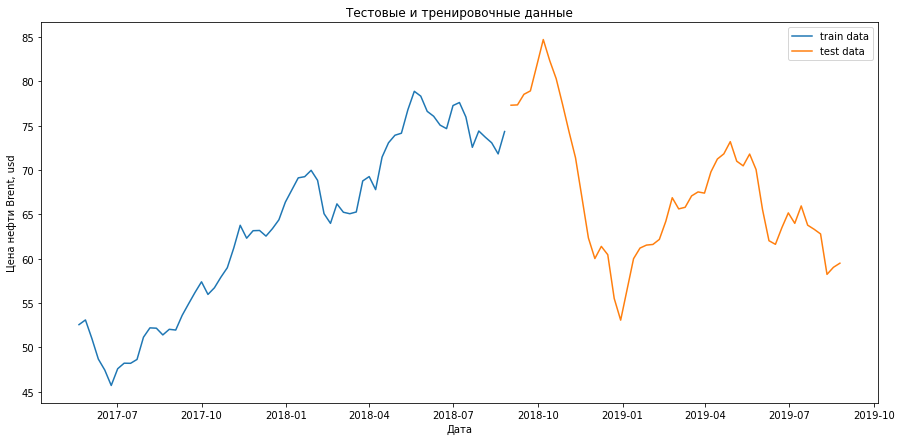

In [189]:
plt.figure( figsize=(15, 7))
plt.plot(train.index, train['Значение'], label='train data' )
plt.plot(test.index, test['Значение'], label='test data')

plt.xlabel('Дата')
plt.ylabel('Цена нефти Brent, usd')
plt.title('Тестовые и тренировочные данные')
plt.legend()
plt.show()

**4. Постройте модель предсказания 1-й точки от текущей (h=1).**

In [190]:
from sklearn.model_selection import RandomizedSearchCV

def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print(f'Model with rank: {i}')
            print('Mean validation score: {0:.3f} (std: {1:.3f})'.format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]
            ))
            print('Parameters: {0}\n'.format(results['params'][candidate]))


param_dist = {
    "max_depth": [2, 3, 5, 10, 15], 
    "n_estimators": [100, 200, 300, 400, 500, 1000, 1200, 1500]
}

model_gr = GradientBoostingRegressor()

random_search = RandomizedSearchCV(model_gr, param_distributions=param_dist, n_iter=10, cv=5, iid=False)

random_search.fit(X_train, y_train)

report(random_search.cv_results_)

Model with rank: 1
Mean validation score: -0.996 (std: 1.949)
Parameters: {'n_estimators': 1500, 'max_depth': 2}

Model with rank: 2
Mean validation score: -1.414 (std: 2.934)
Parameters: {'n_estimators': 1200, 'max_depth': 2}

Model with rank: 3
Mean validation score: -1.858 (std: 3.043)
Parameters: {'n_estimators': 1500, 'max_depth': 3}



In [191]:
model_g = GradientBoostingRegressor(max_depth=2, n_estimators=1500, random_state=42)
model_l = LinearRegression()

In [192]:
model_l.fit(X_train, y_train) 
model_g.fit(X_train, y_train) 

GradientBoostingRegressor(max_depth=2, n_estimators=1500, random_state=42)

In [193]:
y_train_pred_g = model_g.predict(X_train)
y_train_pred_l = model_l.predict(X_train)

y_test_pred_g = model_g.predict(X_test)
y_test_pred_l = model_l.predict(X_test)

In [194]:
print('Ошибка на тренировочной выборке GB:')
calc_errors(scaler_y.inverse_transform(y_train), scaler_y.inverse_transform(y_train_pred_g))

print('Ошибка на тестовой выборке GB:')
calc_errors(scaler_y.inverse_transform(y_test), scaler_y.inverse_transform(y_test_pred_g))

Ошибка на тренировочной выборке GB:
	mse:	3.451839289268132e-15
	mae:	5.009335895343312e-08
	r2:	1.0
	mape:	18.252342297874748
Ошибка на тестовой выборке GB:
	mse:	35.82041169966256
	mae:	4.865180215166113
	r2:	0.33102775194846645
	mape:	11.458199197116977


In [195]:
print('Ошибка на тренировочной выборке LR:')
calc_errors(scaler_y.inverse_transform(y_train), scaler_y.inverse_transform(y_train_pred_l))

print('Ошибка на тестовой выборке LR:')
calc_errors(scaler_y.inverse_transform(y_test), scaler_y.inverse_transform(y_test_pred_l))

Ошибка на тренировочной выборке LR:
	mse:	1.0140074905603726
	mae:	0.8121956735218264
	r2:	0.989368180903143
	mape:	1.2830959431122617
Ошибка на тестовой выборке LR:
	mse:	15.925671287292756
	mae:	3.3060966880186715
	r2:	0.7025765026902144
	mape:	5.136410131685041


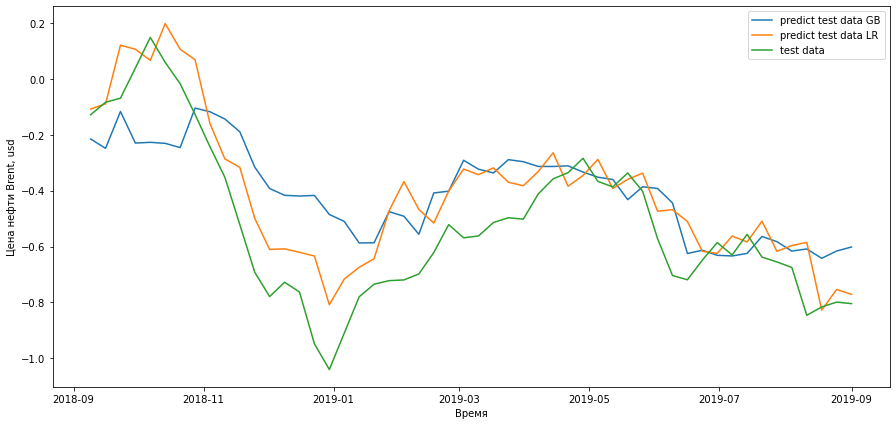

In [196]:
plt.figure(figsize=(15, 7))

plt.xlabel('Время')
plt.ylabel('Цена нефти Brent, usd')

plt.plot(data_week.index[-len(y_test_pred_g):], y_test_pred_g, label='predict test data GB' )
plt.plot(data_week.index[-len(y_test_pred_l):], y_test_pred_l, label='predict test data LR' )
plt.plot(data_week.index[-len(y_test):], y_test, label='test data')

plt.legend()
plt.show()

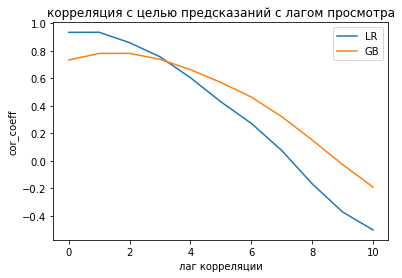

In [197]:
lag=10

p_cor_g = [np.corrcoef(y_test.ravel(), y_test_pred_g)[1,0]]
p_cor_l = [np.corrcoef(y_test.ravel(), y_test_pred_l.ravel())[1,0]]

for i in range(lag):
    c_g = np.corrcoef(y_test.ravel()[:-(i+1)], y_test_pred_g[(i+1):])[1,0]
    c_l = np.corrcoef(y_test.ravel()[:-(i+1)], y_test_pred_l.ravel()[(i+1):])[1,0]
    p_cor_g.append(c_g)
    p_cor_l.append(c_l)    

plt.xlabel('лаг корреляции')
plt.ylabel('cor_coeff')

plt.plot(np.arange(lag+1), np.array(p_cor_l), label='LR')  
plt.plot(np.arange(lag+1), np.array(p_cor_g), label='GB')  

plt.title('корреляция с целью предсказаний с лагом просмотра')
plt.legend()
plt.show()

**5. Добавьте еще один любой экзогенный фактор.**

### Добавление экзогенного признака

In [198]:
gold = pd.read_csv('./datasets/gold_2010_2019.csv', index_col=[0], parse_dates=[0]).sort_index()

gold.head()

,gold
data,
2010-08-26,1238.9
2010-08-27,1237.9
2010-08-29,1238.1
2010-08-30,1237.8
2010-08-31,1249.8


In [199]:
data_with_gold = data_week.merge(gold.resample('W').mean(), how='left', left_index=True, right_index=True)
data_with_gold.head()

,Значение,year,month,dayofmonth,quarter,weekofyear,is_holiday,is_prev_holiday,is_next_holiday,usd,...,eur_t_52,eur_t_53,eur_t_54,eur_t_55,eur_t_56,eur_t_57,eur_t_58,eur_t_59,eur_t_60,gold
Дата,,,,,,,,,,,,,,,,,,,,,
2010-09-05,76.616000,2010.0,9.000000,3.000000,3.000000,35.0,0.000000,0.2,0.000000,30.76125,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1248.483333
2010-09-12,77.673333,2010.0,9.000000,8.500000,3.000000,36.0,0.166667,0.0,0.166667,30.79402,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1251.733333
2010-09-19,78.693333,2010.0,9.000000,15.666667,3.000000,37.0,0.000000,0.0,0.000000,30.78775,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1271.100000
2010-09-26,78.518333,2010.0,9.000000,22.666667,3.000000,38.0,0.000000,0.0,0.000000,31.01200,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1292.483333
2010-10-03,81.211667,2010.0,9.333333,19.666667,3.333333,39.0,0.000000,0.0,0.000000,30.53220,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1311.083333


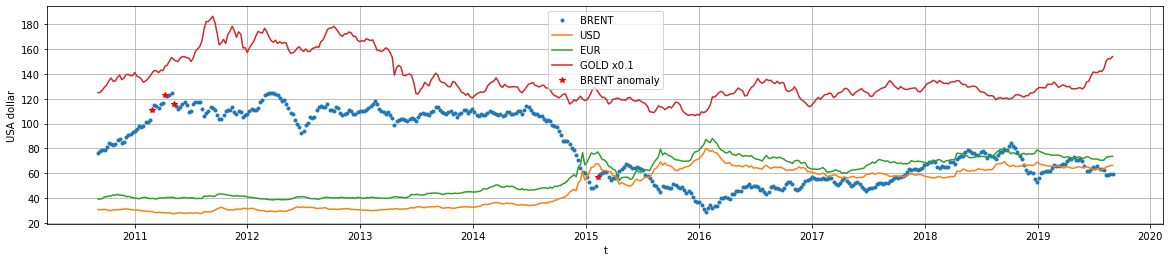

In [200]:
plt.figure(figsize=(20,4))

plt.plot(data_with_gold.index, data_with_gold['Значение'], '.', label='BRENT')
plt.plot(data_with_gold.index, data_with_gold['usd'], '-', label='USD')
plt.plot(data_with_gold.index, data_with_gold['eur'], '-', label='EUR')
plt.plot(data_with_gold.index, data_with_gold['gold']*0.1, '-', label='GOLD x0.1')
plt.plot(data_with_gold.iloc[ind_anomal_brent].index, data_with_gold['Значение'].values[ind_anomal_brent], '*r', label='BRENT anomaly')
plt.ylabel('USA dollar')
plt.grid()
plt.xlabel('t')
plt.legend()
plt.show()

In [201]:
feature_list = np.append(feature_list, len(data_with_gold.columns)-1)
data_with_gold.columns[feature_list]

Index(['Значение', 't_1', 't_2', 't_3', 't_4', 't_5', 't_6', 't_7', 't_8',
       'd_22', 'd_40', 'usd_t_51', 'usd_t_52', 'usd_t_53', 'usd_t_54',
       'usd_t_55', 'usd_t_56', 'usd_t_57', 'usd_t_58', 'usd_t_59', 'usd_t_60',
       'eur_t_1', 'eur_t_2', 'eur_t_3', 'eur_t_4', 'eur_t_5', 'eur_t_13',
       'eur_t_59', 'eur_t_60', 'gold'],
      dtype='object')

### Стандартизация и разбиение на тестовые и тренировочные данные

In [202]:
scaler_y = StandardScaler()
scaler_y.fit(data_with_gold['Значение'].values.reshape((data_with_gold.shape[0], 1)))

scaler_x = StandardScaler()
scaler_x.fit(data_with_gold.iloc[:,feature_list].values)

StandardScaler()

In [213]:
h = 1

X = data_with_gold.iloc[start_index:-h, feature_list]
y = data_with_gold['Значение'].values[h+start_index:].reshape((data_with_gold.shape[0]-h-start_index, 1))

train, test = split_data(X, '09-01-2018')

X_train = scaler_x.transform(train.values)
X_test = scaler_x.transform(test.values)
y_train = scaler_y.transform(y[:train.shape[0]])
y_test = scaler_y.transform(y[-test.shape[0]:])

### Построение модели

In [214]:
param_dist = {
    "max_depth": [2, 3, 5, 10, 15], 
    "n_estimators": [100, 200, 300, 400, 500, 1000, 1200, 1500]
}

model_gr = GradientBoostingRegressor()

random_search = RandomizedSearchCV(model_gr, param_distributions=param_dist, n_iter=10, cv=5, iid=False)

random_search.fit(X_train, y_train)

report(random_search.cv_results_)

Model with rank: 1
Mean validation score: -1.369 (std: 2.496)
Parameters: {'n_estimators': 1000, 'max_depth': 2}

Model with rank: 2
Mean validation score: -1.818 (std: 3.039)
Parameters: {'n_estimators': 400, 'max_depth': 5}

Model with rank: 3
Mean validation score: -2.008 (std: 3.079)
Parameters: {'n_estimators': 500, 'max_depth': 10}



In [215]:
model_g = GradientBoostingRegressor(max_depth=2, n_estimators=1000, random_state=42)
model_l = LinearRegression()

In [216]:
model_l.fit(X_train, y_train) 
model_g.fit(X_train, y_train) 

GradientBoostingRegressor(max_depth=2, n_estimators=1000, random_state=42)

In [217]:
y_train_pred_g = model_g.predict(X_train)
y_train_pred_l = model_l.predict(X_train)

y_test_pred_g = model_g.predict(X_test)
y_test_pred_l = model_l.predict(X_test)

In [218]:
print('Ошибка на тренировочной выборке GB:')
calc_errors(scaler_y.inverse_transform(y_train), scaler_y.inverse_transform(y_train_pred_g))

print('Ошибка на тестовой выборке GB:')
calc_errors(scaler_y.inverse_transform(y_test), scaler_y.inverse_transform(y_test_pred_g))

Ошибка на тренировочной выборке GB:
	mse:	6.201382408390637e-11
	mae:	6.44955401748487e-06
	r2:	0.9999999999993497
	mape:	18.252341849399244
Ошибка на тестовой выборке GB:
	mse:	35.83872381650225
	mae:	4.84488918302001
	r2:	0.33068575984431237
	mape:	11.533815920563226


In [219]:
print('Ошибка на тренировочной выборке LR:')
calc_errors(scaler_y.inverse_transform(y_train), scaler_y.inverse_transform(y_train_pred_l))

print('Ошибка на тестовой выборке LR:')
calc_errors(scaler_y.inverse_transform(y_test), scaler_y.inverse_transform(y_test_pred_l))

Ошибка на тренировочной выборке LR:
	mse:	0.997326537808481
	mae:	0.7942226616254281
	r2:	0.9895430798794054
	mape:	1.2505748127651877
Ошибка на тестовой выборке LR:
	mse:	10.668228288903414
	mae:	2.6966346556726526
	r2:	0.8007630755058599
	mape:	4.184806339750963


### Визуализация результатов

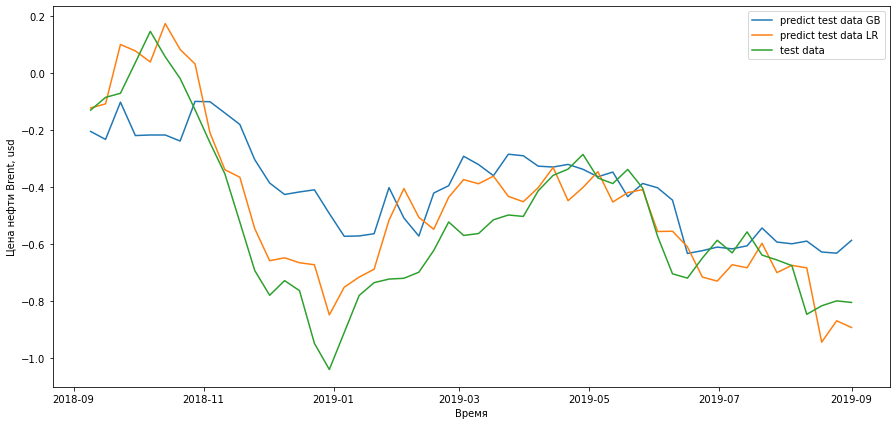

In [220]:
plt.figure(figsize=(15, 7))

plt.xlabel('Время')
plt.ylabel('Цена нефти Brent, usd')

plt.plot(data_week.index[-len(y_test_pred_g):], y_test_pred_g, label='predict test data GB' )
plt.plot(data_week.index[-len(y_test_pred_l):], y_test_pred_l, label='predict test data LR' )
plt.plot(data_week.index[-len(y_test):], y_test, label='test data')

plt.legend()
plt.show()

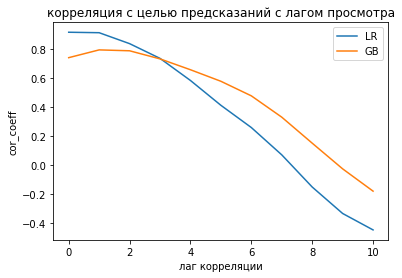

In [221]:
lag=10

p_cor_g = [np.corrcoef(y_test.ravel(), y_test_pred_g)[1,0]]
p_cor_l = [np.corrcoef(y_test.ravel(), y_test_pred_l.ravel())[1,0]]

for i in range(lag):
    c_g = np.corrcoef(y_test.ravel()[:-(i+1)], y_test_pred_g[(i+1):])[1,0]
    c_l = np.corrcoef(y_test.ravel()[:-(i+1)], y_test_pred_l.ravel()[(i+1):])[1,0]
    p_cor_g.append(c_g)
    p_cor_l.append(c_l)    

plt.xlabel('лаг корреляции')
plt.ylabel('cor_coeff')

plt.plot(np.arange(lag+1), np.array(p_cor_l), label='LR')  
plt.plot(np.arange(lag+1), np.array(p_cor_g), label='GB')  

plt.title('корреляция с целью предсказаний с лагом просмотра')
plt.legend()
plt.show()

**6. Сравните модель с дополнительным экзогенным фактором и исходную и сделайте вывод о поведении ошибки предсказания ряда в сравнении с прямым прогнозированием.**

Для модели градиентного бустинга и линейной регрессии ошибка MAPE на тренировочной выборке практически не изменилась. 

На тестовой выборке для модели градиентного бустинга ошибка MAPE уменьшилась с $21.26\%$ до $20.66\%$.

На тестовой выборке для модели линейной регрессии ошибка MAPE уменьшилась с $2.86\%$ до $2.81\%$.

Добавление нового признака улучшает качество модели.

Из графиков лаговой корреляции видно что модель линейной регрессии переобучилась и предсказывает что завтра нефть будет стоить столько же, сколько и сегодня.